<a href="https://colab.research.google.com/github/vladlee098/kaggle/blob/master/household_power_consumption_ts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
from google.colab import files
files.upload()

Saving household_power_consumption.zip to household_power_consumption.zip


In [10]:
!unzip \*.zip

Archive:  household-electric-power-consumption.zip
  inflating: household_power_consumption.txt  

Archive:  household_power_consumption.zip
  inflating: household_power_consumption.csv  

2 archives were successfully processed.


In [0]:
import os
import sys
import warnings

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt  
import seaborn as sns  

import datetime as dt
from collections import UserDict
from sklearn.preprocessing import MinMaxScaler
from IPython.display import Image

In [0]:
#!pip install mxnet
#!pip install gluonts

The description of data can be found here: http://archive.ics.uci.edu/ml/datasets/Individual+household+electric+power+consumption

Attribute Information: 

1.date: Date in format dd/mm/yyyy

2.time: time in format hh:mm:ss

3.global_active_power: household global minute-averaged active power (in kilowatt)

4.global_reactive_power: household global minute-averaged reactive power (in kilowatt)

5.voltage: minute-averaged voltage (in volt)

6.global_intensity: household global minute-averaged current intensity (in ampere)

7.sub_metering_1: energy sub-metering No. 1 (in watt-hour of active energy). It corresponds to the kitchen, containing mainly a dishwasher, an oven and a microwave (hot plates are not electric but gas powered).

8.sub_metering_2: energy sub-metering No. 2 (in watt-hour of active energy). It corresponds to the laundry room, containing a washing-machine, a tumble-drier, a refrigerator and a light.

9.sub_metering_3: energy sub-metering No. 3 (in watt-hour of active energy). It corres

In [0]:
df = pd.read_csv('household_power_consumption.txt', sep=';', 
                 parse_dates={'dt' : ['Date', 'Time']}, infer_datetime_format=True, 
                 low_memory=False, na_values=['nan','?'], index_col='dt')

In [4]:
df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
dt,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [5]:
df.describe()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
count,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06
mean,1.091615e+00,1.237145e-01,2.408399e+02,4.627759e+00,1.121923e+00,1.298520e+00,6.458447e+00
std,1.057294e+00,1.127220e-01,3.239987e+00,4.444396e+00,6.153031e+00,5.822026e+00,8.437154e+00
min,7.600000e-02,0.000000e+00,2.232000e+02,2.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.080000e-01,4.800000e-02,2.389900e+02,1.400000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,6.020000e-01,1.000000e-01,2.410100e+02,2.600000e+00,0.000000e+00,0.000000e+00,1.000000e+00
75%,1.528000e+00,1.940000e-01,2.428900e+02,6.400000e+00,0.000000e+00,1.000000e+00,1.700000e+01
max,1.112200e+01,1.390000e+00,2.541500e+02,4.840000e+01,8.800000e+01,8.000000e+01,3.100000e+01


In [0]:
# filling nan with mean in any columns

for j in range(0,7):        
    df.iloc[:,j]=df.iloc[:,j].fillna(df.iloc[:,j].mean())

In [7]:
df.isnull().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

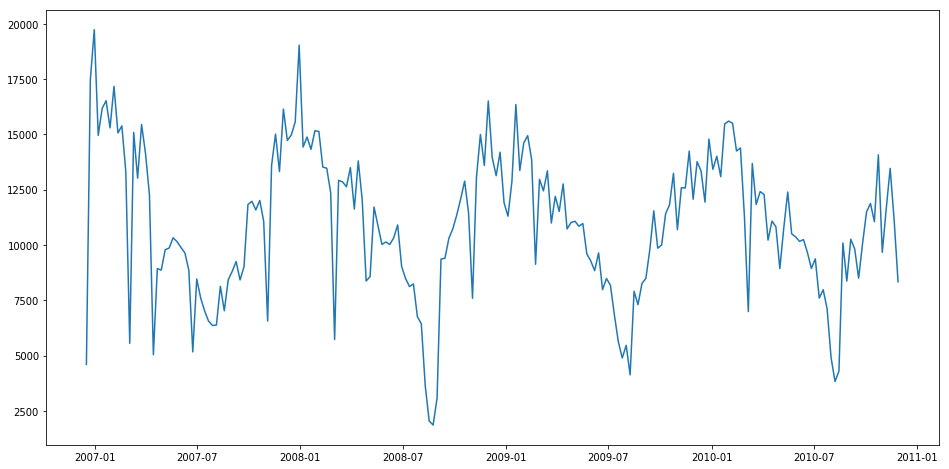

In [9]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

## resample 

weekly_sum = df.resample('W').sum()
plt.figure(figsize=(16,8))
plt.plot(weekly_sum.index, weekly_sum['Global_active_power'].values)
plt.show()

In [12]:
weekly_sum.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 207 entries, 2006-12-17 to 2010-11-28
Freq: W-SUN
Data columns (total 7 columns):
Global_active_power      207 non-null float64
Global_reactive_power    207 non-null float64
Voltage                  207 non-null float64
Global_intensity         207 non-null float64
Sub_metering_1           207 non-null float64
Sub_metering_2           207 non-null float64
Sub_metering_3           207 non-null float64
dtypes: float64(7)
memory usage: 12.9 KB


# Time-Series Forecasting Using Deep Learning

##GluonTS Introduction


##GluonTS

Gluon toolkit for time series modeling using MXNET
Build custom time series models (components for feature engineering, calendar features, etc)
Support various time series use cases, i.e., classification or anomaly detection
Pre-built models (Deep Learning, DeepAR, RNN, etc)
Model evaluation and visualization
Synthetic and real-world datasets

In [0]:
import mxnet as mx
from mxnet import gluon
from gluonts.model.r_forecast import RForecastPredictor

from gluonts.model.simple_feedforward import SimpleFeedForwardEstimator
from gluonts.model.deepar import DeepAREstimator
from gluonts.trainer import Trainer
import pandas as pd
import matplotlib.pyplot as plt
import json

from itertools import islice
from gluonts.evaluation.backtest import make_evaluation_predictions

In [18]:
start = pd.Timestamp("2006-12-17", freq='W')
train_ds = [{'target': weekly_sum[column].head(-39).values, 'start': start} for column in weekly_sum]
test_ds = [{'target': weekly_sum[column].values, 'start': start} for column in weekly_sum]

estimator = SimpleFeedForwardEstimator(
    num_hidden_dimensions=[30,30],
    prediction_length=39,
    context_length=52,
    freq='1W',
    trainer=Trainer(ctx="cpu", 
                    epochs=50, 
                    learning_rate=1E-3, 
                    hybridize=False, 
                    num_batches_per_epoch=50
                   )
)

predictor = estimator.train(train_ds)

INFO:root:Start model training
INFO:root:Number of parameters in SimpleFeedForwardTrainingNetwork: 1203
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 81.42it/s, avg_epoch_loss=11]
INFO:root:Epoch[0] Elapsed time 0.618 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=11.027172
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 111.03it/s, avg_epoch_loss=10.5]
INFO:root:Epoch[1] Elapsed time 0.453 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=10.492117
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 108.18it/s, avg_epoch_loss=10.4]
INFO:root:Epoch[2] Elapsed time 0.465 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=10.366264
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 112.21it/s, avg_epoch_loss=10.3]
INFO:root:Epoch[3] Elapsed time 0.449 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=10.319718
INFO:root:Epoch[4] Learning

In [21]:
# This function returns generators
forecast_it, ts_it = make_evaluation_predictions(
    test_ds, 
    predictor=predictor, 
    num_eval_samples=200)

#  Convert these generators to lists to ease the subsequent computations
forecasts_DNN = list(forecast_it)
tss_DNN = list(ts_it)

len(tss_DNN)
f_entry = forecasts_DNN[0]
tss_DNN[0].head(10)

,0
2006-12-17,4599.636000
2006-12-24,17479.311230
2006-12-31,19738.701230
2007-01-07,14961.068000
2007-01-14,16177.425615
2007-01-21,16525.666000
2007-01-28,15295.671615
2007-02-04,17172.372000
2007-02-11,15068.946000
2007-02-18,15385.376000


In [22]:
print(f"Frequency of the time series: {f_entry.freq}")
print(f"Start date of the forecast window: {f_entry.start_date}")
print(f"Number of sample paths: {f_entry.num_samples}")
print(f"Dimension of samples: {f_entry.samples.shape}")

#Compute the mean or a given quantile of the forecast
print(f"Mean of the future window:\n {f_entry.mean}")
print(f"0.5-quantile (median) of the future window:\n {f_entry.quantile(0.5)}")

Frequency of the time series: 1W
Start date of the forecast window: 2010-03-07 00:00:00
Number of sample paths: 200
Dimension of samples: (200, 39)
Mean of the future window:
 [13546.821  13421.611  12657.503  12709.457  12641.92   13044.914
 12120.282  11941.324  10928.909  10728.245   9761.271  10310.41
  9944.622   9085.178   8731.763   8634.572   8424.015   8407.199
  7713.406   7366.9326  7955.8145  8154.6714  7267.995   7861.483
  8257.395   7638.0205  8965.941   9036.336  10075.86    9954.128
 11032.872  10632.763  11227.682  12408.008  12706.503  12728.894
 12800.834  13894.906  13329.461 ]
0.5-quantile (median) of the future window:
 [13457.212  13271.026  12611.816  12606.805  12475.133  12759.231
 12240.692  11990.848  11223.852  10627.303  10010.441  10264.085
  9749.514   8961.658   8700.406   8669.217   8639.351   8309.258
  8139.8257  7732.3823  7944.1895  8021.4497  7547.3647  7879.903
  8356.776   7827.4414  8941.865   9022.288  10016.323   9904.269
 10811.262  10608.5

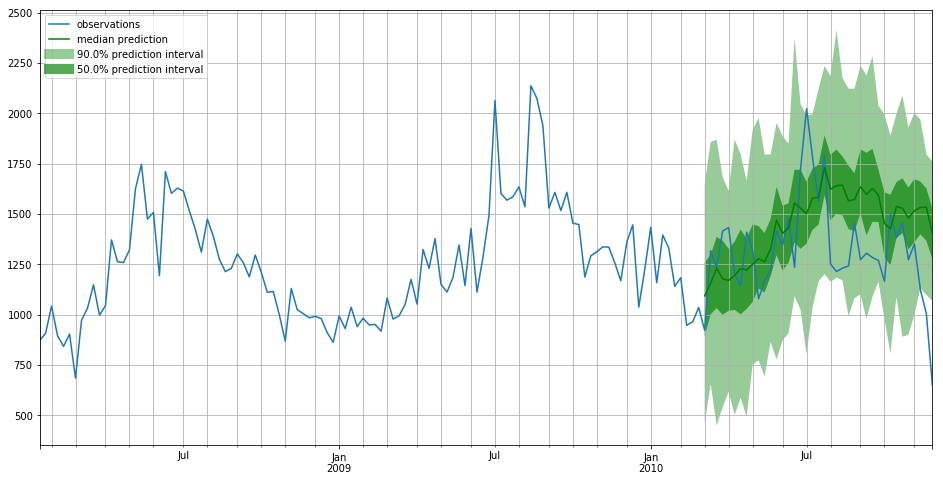

In [37]:
def plot_prob_forecasts(ts_entry, forecast_entry):
    plot_length = 150
    prediction_intervals = (50.0, 90.0)
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(16, 8))
    ts_entry[-plot_length:].plot(ax=ax)  # plot the time series
    forecast_entry.plot(prediction_intervals=prediction_intervals, color='g')
    plt.grid(which="both")
    plt.legend(legend, loc="upper left")
    plt.show()
    
id = 1
plot_prob_forecasts(tss_DNN[id], forecasts_DNN[id])    

In [26]:
from gluonts.evaluation import Evaluator

evaluator = Evaluator(quantiles=[0.5])
agg_metrics_DNN, item_metrics_DNN = evaluator(iter(tss_DNN), iter(forecasts_DNN), num_series=len(test_ds))

Running evaluation: 100%|██████████| 7/7 [00:00<00:00, 142.36it/s]


In [27]:
item_metrics_DNN.head()

,Coverage[0.5],MASE,MSE,MSIS,QuantileLoss[0.5],abs_error,abs_target_mean,abs_target_sum,item_id,sMAPE,seasonal_error
0,0.487179,0.905906,4.203608e+06,36.236240,5.800798e+04,5.800798e+04,9.904302e+03,3.862678e+05,NaN,0.160657,1641.874793
1,0.692308,1.515864,8.025528e+04,60.634561,8.757389e+03,8.757389e+03,1.324781e+03,5.166644e+04,NaN,0.165986,148.132304
2,0.794872,5.309788,2.979223e+10,212.391508,4.022832e+06,4.022832e+06,2.412369e+06,9.408238e+07,NaN,0.042986,19426.301742
3,0.487179,0.912930,6.998410e+07,36.517187,2.438822e+05,2.438822e+05,4.200621e+04,1.638242e+06,NaN,0.158630,6849.804947
4,0.641026,0.848321,2.545461e+07,33.932848,1.470173e+05,1.470173e+05,9.353703e+03,3.647944e+05,NaN,0.453059,4443.688153


In [29]:
from gluonts.model.seasonal_naive import SeasonalNaivePredictor

seasonal_predictor_1W = SeasonalNaivePredictor(freq="W", prediction_length=39)

forecast_it, ts_it = make_evaluation_predictions(test_ds,predictor=seasonal_predictor_1W, num_eval_samples=200)
forecasts_naive = list(forecast_it)
tss_naive = list(ts_it)

agg_metrics_naive, item_metrics_naive = evaluator(iter(tss_naive), iter(forecasts_naive), num_series=len(test_ds))

Running evaluation: 100%|██████████| 7/7 [00:00<00:00, 157.35it/s]


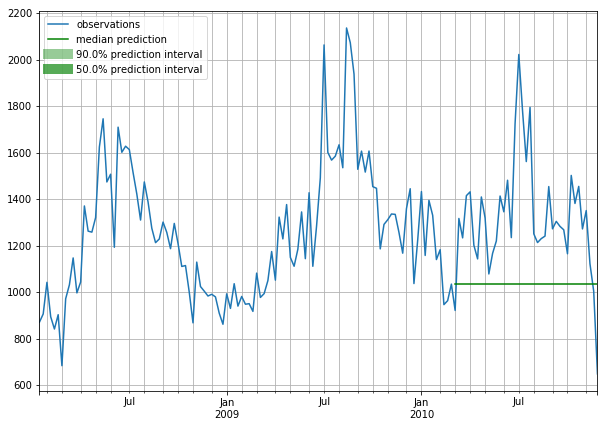

In [30]:
id = 1
plot_prob_forecasts(tss_naive[id], forecasts_naive[id])